# Figure 11.2

Observed changes in Tglob, Tland, TXx, & TNn

Author: Mathias Hauser

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import hadex3
import conf

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.sans-serif'] = "Arial"

## Load data

### Tglob & Tland (from Chapter 2)

In [2]:
fN = "../data/ch2_glob_land_temp/glob_temp.csv"
tglob = pd.read_csv(fN, header=2, index_col=0, skipinitialspace=True)
tglob = tglob.to_xarray().glob_mean

In [3]:
fN = "../data/ch2_glob_land_temp/land_temp.csv"
tland = pd.read_csv(fN, header=2, index_col=0, skipinitialspace=True)
tland = tland.to_xarray().land_mean

### Hadex3

we use HadEX3 from 1961 on - there are some jumps in the data in some regions when low-elevation stations are added (in South America and the Himalayas)

Also in 1961 a large part of South America is added which leads to a jump in TNn...

In [4]:
# time period where data must be non-NaN
time_valid = slice("1961", None)

# climatology period of HadEX3 data
clim = slice("1961", "1990")

In [5]:
landmask = hadex3.HadEx3.read_landmask()
hadex_weights = np.cos(np.deg2rad(landmask.lat))

In [6]:
def hadex_calc_ave(dta, lat=None, minimum_valid=0.9):

    dta = hadex3.valid_for_globmean(dta, minimum_valid=minimum_valid)
    
    dta = dta if lat is None else dta.sel(lat=lat)
    dta = dta.weighted(hadex_weights).mean(("lat", "lon"))
    return dta - dta.sel(time=clim).mean("time")

#### TXx

In [7]:
TXx_orig_map = hadex3.HadEx3.read_file("TXx")
TXx_map = TXx_orig_map.sel(time=time_valid)

In [8]:
TXx = hadex_calc_ave(TXx_map)

minimum_valid removed 11.52 % valid gridpoints


#### TNn

In [9]:
TNn_orig_map = hadex3.HadEx3.read_file("TNn")
TNn_map = TNn_orig_map.sel(time=time_valid)

In [10]:
TNn = hadex_calc_ave(TNn_map)

minimum_valid removed 8.09 % valid gridpoints


#### Calculate offset

In [11]:
offset = tglob.sel(year=clim).mean().item()

offset

0.3561

## Plot

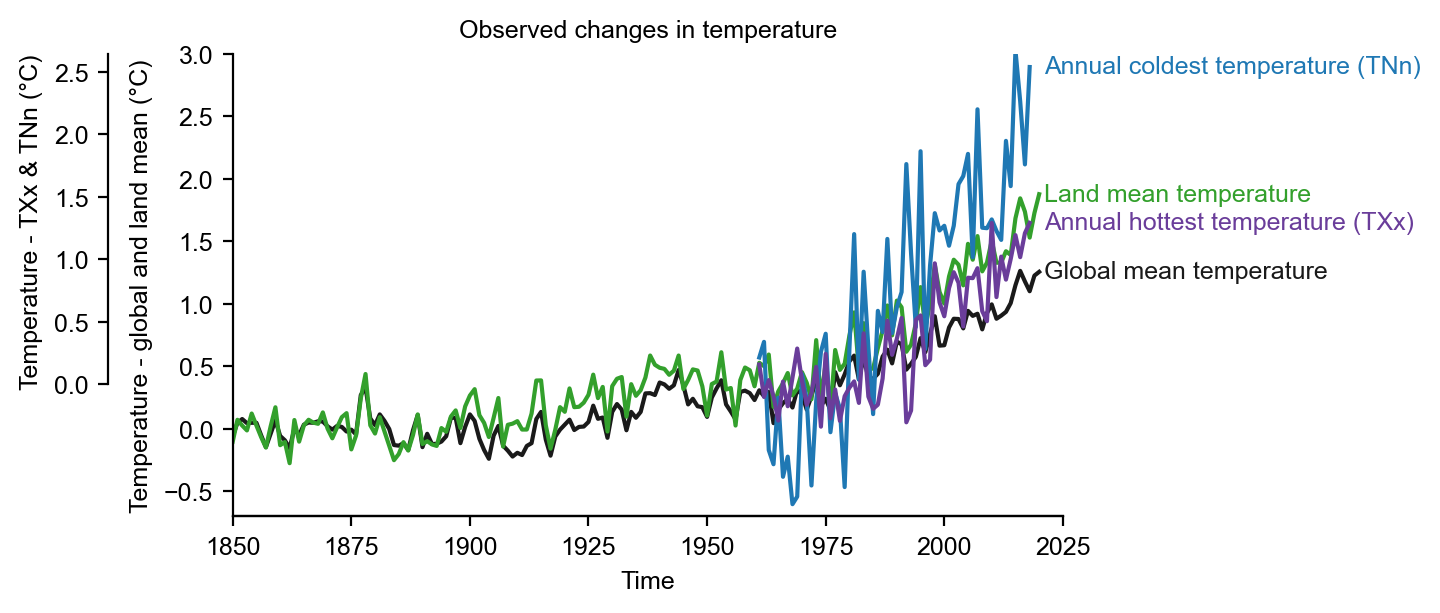

In [12]:
def create_ts_plot(
    TNn_to_plot,
    TXx_to_plot,
    ylim=np.array([-0.7, 3.0]),
    label_txx="Annual hottest temperature (TXx)",
    label_tnn="Annual coldest temperature (TNn)",
    tglob_label_offset=0.0,
    txx_label_offset=0,
):

    f, ax = plt.subplots(constrained_layout=True)
    f.set_size_inches(18 / 2.54, 7.5 / 2.54)

    twinax = ax.twinx()

    x_annot = 2021

    twinax.spines["left"].set_position(("axes", -0.15))
    twinax.spines["left"].set_visible(True)
    twinax.yaxis.set_label_position("left")
    twinax.yaxis.set_ticks_position("left")

    # =====

    tglob.plot(ax=ax, color="0.1")

    ax.annotate(
        "Global mean temperature",
        xy=(x_annot, tglob.values[-1].item() + tglob_label_offset),
        color="0.1",
        va="center",
        size=9,
    )

    # =====

    tland.plot(ax=ax, color="#33a02c")

    ax.annotate(
        "Land mean temperature",
        xy=(x_annot, tland.values[-1].item()),
        color="#33a02c",
        va="center",
        size=9,
    )

    # =====

    TNn_to_plot.plot(
        ax=twinax, color="#1f78b4", label="Annual coldest temperature (TNn)", zorder=0.1
    )

    twinax.annotate(
        label_tnn,
        xy=(x_annot, TNn_to_plot[-1].item()),
        color="#1f78b4",
        va="center",
        size=9,
    )

    # =====

    TXx_to_plot.plot(
        ax=twinax, color="#6a3d9a", label="Annual hottest temperature (TXx)"
    )

    twinax.annotate(
        label_txx,
        xy=(x_annot, TXx_to_plot[-1].item() + txx_label_offset),
        color="#6a3d9a",
        va="center",
        size=9,
    )

    # =====

    ax.set_ylabel("Temperature - global and land mean (°C)", fontsize=9)
    twinax.set_ylabel("Temperature - TXx & TNn (°C)", fontsize=9, loc="top")
    ax.set_xlabel("Time", fontsize=9)

    ax.tick_params(axis="both", which="major", labelsize=9)
    ax.set_title("Observed changes in temperature", fontsize=9)

    twinax.tick_params(axis="both", which="major", labelsize=9)

    # ax.legend()

    ax.set_ylim(ylim)
    ax.set_xlim(1850, 2025)

    twinax.set_ylim(ylim - offset)

    twinax.set_yticks(np.arange(0, ylim[1] - offset + 0.1, 0.5))

    s = twinax.spines["left"]
    s.set_bounds(0, ylim[1] - offset)

    sns.despine(f)

    ax.set_xticks(np.arange(1850, 2026, 25))

    return f, ax


ylim_orig = np.array([-0.7, 3.0])
f, ax = create_ts_plot(TNn, TXx, ylim=ylim_orig)

fN = conf.figure_filename("Figure_11.2", "Figure_11.2_obs_ts_plots")
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".png", dpi=300, facecolor="w")